In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [3]:
num_symbols = 101
sps = 8 #samples per symbol

msg = 'Hello World'.encode('utf-8')
bytes = np.frombuffer(msg,dtype='uint8')
bits = np.unpackbits(bytes)


In [9]:
preamble = np.array([1,1,1,0,0,0,1,0,0,1,0])
preamble2 = np.concatenate((preamble,preamble))
data = np.concatenate((preamble2,bits))

In [10]:
x = np.array([])
for bit in data:
    pulse = np.zeros(sps)
    pulse[0] = bit*2-1 # set the first value to either a 1 or -1
    x = np.concatenate((x, pulse)) # add the 8 samples to the signal

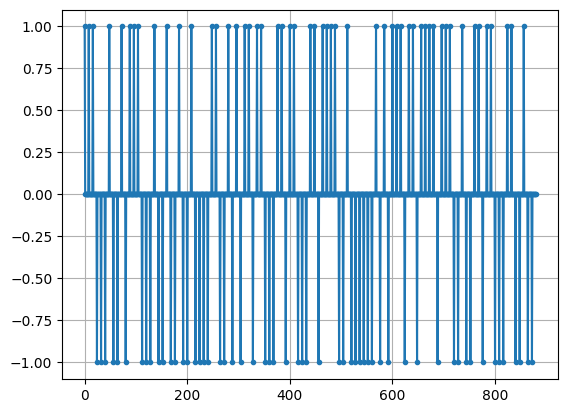

In [11]:
plt.figure(0)
plt.plot(x, '.-')
plt.grid(True)
plt.show()

In [12]:
# Create our raised-cosine filter
num_taps = 101
beta = 0.35
Ts = sps # Assume sample rate is 1 Hz, so sample period is 1, so *symbol* period is 8
t = np.arange(-50, 51) # remember it's not inclusive of final number
h = np.sinc(t/Ts) * np.cos(np.pi*beta*t/Ts) / (1 - (2*beta*t/Ts)**2)

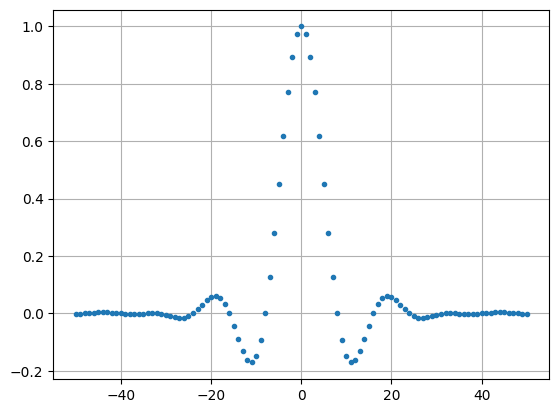

In [13]:
plt.figure(1)
plt.plot(t, h, '.')
plt.grid(True)
plt.show()

In [14]:
# Filter our signal, in order to apply the pulse shaping
x_shaped = np.convolve(x, h)

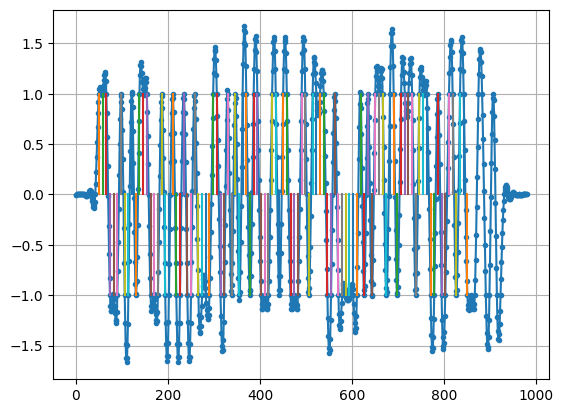

In [15]:
plt.figure(2)
plt.plot(x_shaped, '.-')
for i in range(num_symbols):
    plt.plot([i*sps+num_taps//2,i*sps+num_taps//2], [0, x_shaped[i*sps+num_taps//2]])
plt.grid(True)
plt.show()

In [17]:
# Create and apply fractional delay filter
delay = 1.4 # fractional delay, in samples
N = 21 # number of taps
num_taps2=N+num_taps
n = np.arange(-N//2, N//2) # ...-3,-2,-1,0,1,2,3...
h = np.sinc(n - delay) # calc filter taps
h *= np.hamming(N) # window the filter to make sure it decays to 0 on both sides
h /= np.sum(h) # normalize to get unity gain, we don't want to change the amplitude/power


In [18]:
x_delayed = np.convolve(x_shaped, h) # apply filter


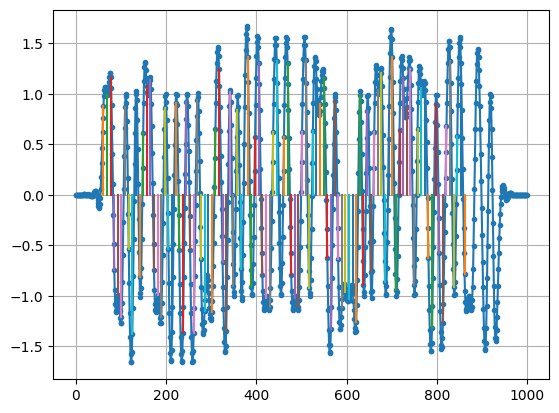

In [19]:
plt.figure(3)
plt.plot(x_delayed, '.-')
for i in range(num_symbols):
    plt.plot([i*sps+num_taps2//2,i*sps+num_taps2//2], [0, x_delayed[i*sps+num_taps2//2]])
plt.grid(True)
plt.show()


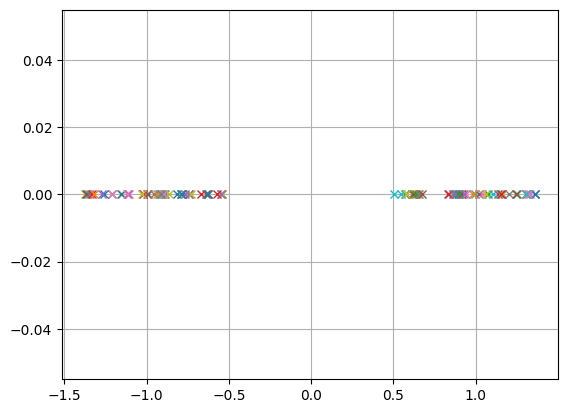

In [20]:
plt.figure(4)
for i in range(num_symbols):
    plt.plot(x_delayed[i*sps+num_taps2//2],0,'x')
plt.grid(True)
plt.show()


In [21]:
# apply a freq offset
fs = 1e6 # assume our sample rate is 1 MHz
fo = 100 # simulate freq offset
Ts = 1/fs # calc sample period
t = np.arange(0, len(x_delayed))*Ts # create time vector
x_fo = x_delayed * np.exp(1j*2*np.pi*fo*t) # perform freq shift


In [22]:
corr=np.abs(np.correlate(x_fo,x_shaped[num_taps//2:num_taps//2+2*11*sps],'full'))

In [25]:
frame_start = np.argmax(corr)-2*11*sps
print('Detected frame start:', frame_start)
print('Real frame start:', num_taps2//2)

Detected frame start: 61
Real frame start: 61


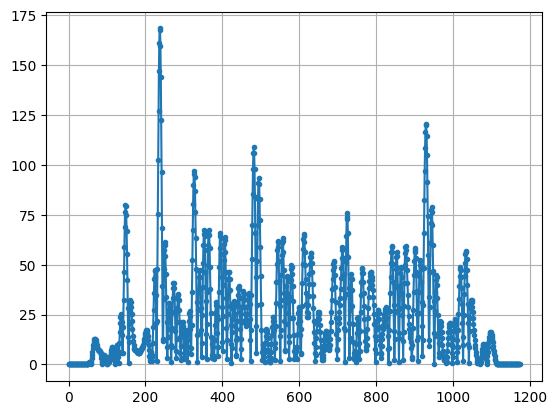

In [26]:
plt.plot(corr,'.-')
plt.grid()
plt.show()

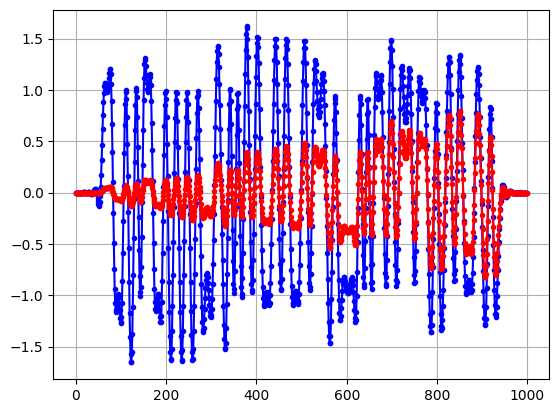

In [27]:
plt.figure(5)
plt.plot(np.real(x_fo), 'b.-')
plt.plot(np.imag(x_fo), 'r.-')
plt.grid(True)
plt.show()


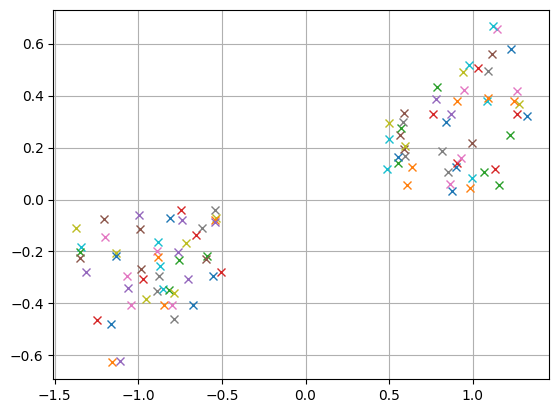

In [28]:
plt.figure(5)
for i in range(num_symbols):
    plt.plot(np.real(x_fo[i*sps+num_taps2//2]),np.imag(x_fo[i*sps+num_taps2//2]),'x')
plt.grid(True)
plt.show()


In [32]:
# Muller muller
samples_interpolated = signal.resample_poly(x_fo, 16, 1)
mu = 0 # initial estimate of phase of sample
out = np.zeros(len(x_fo) + 10, dtype=complex)
out_rail = np.zeros(len(x_fo) + 10, dtype=complex) # stores values, each iteration we need the previous 2 values plus current value
i_in = num_taps2//2 # input samples index
i_out = 2 # output index (let first two outputs be 0)
while i_out < len(x_fo) and i_in < len(x_fo):
    out[i_out] = samples_interpolated[i_in*16 + int(mu*16)]
    out_rail[i_out] = int(np.real(out[i_out]) > 0) + 1j*int(np.imag(out[i_out]) > 0)
    x = (out_rail[i_out] - out_rail[i_out-2]) * np.conj(out[i_out-1])
    y = (out[i_out] - out[i_out-2]) * np.conj(out_rail[i_out-1])
    mm_val = np.real(y - x)
    mu += sps + 0.3*mm_val
    i_in += int(np.floor(mu)) # round down to nearest int since we are using it as an index
    mu = mu - np.floor(mu) # remove the integer part of mu
    i_out += 1 # increment output index
out = out[2:i_out] # remove the first two, and anything after i_out (that was never filled out)
samples_synched = out


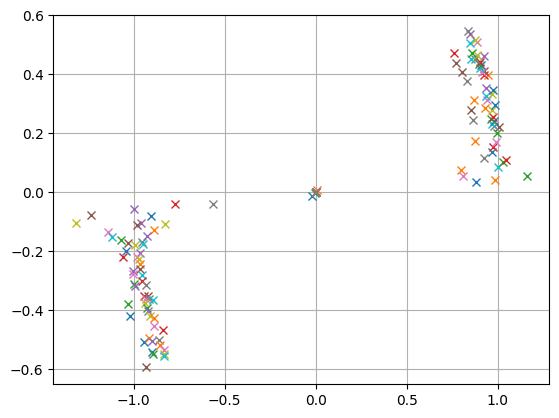

In [33]:
plt.figure(6)
for i in range(len(out)):
    plt.plot(np.real(out[i]),np.imag(out[i]),'x')
plt.grid(True)
plt.show()

In [35]:
N = len(samples_synched)
phase = 0
freq = 0
# These next two params is what to adjust, to make the feedback loop faster or slower (which impacts stability)
alpha = 0.132
beta = 0.00932
out = np.zeros(N, dtype=complex)
freq_log = []
for i in range(N):
    out[i] = samples_synched[i] * np.exp(-1j*phase) # adjust the input sample by the inverse of the estimated phase offset
    error = np.real(out[i]) * np.imag(out[i]) # This is the error formula for 2nd order Costas Loop (e.g. for BPSK)

    # Advance the loop (recalc phase and freq offset)
    freq += (beta * error)
    freq_log.append(freq * fs / (2*np.pi)) # convert from angular velocity to Hz for logging
    phase += freq + (alpha * error)

    # Optional: Adjust phase so its always between 0 and 2pi, recall that phase wraps around every 2pi
    while phase >= 2*np.pi:
        phase -= 2*np.pi
    while phase < 0:
        phase += 2*np.pi


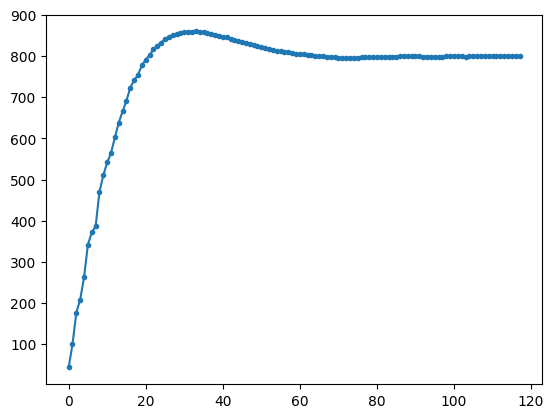

In [36]:
# Plot freq over time to see how long it takes to hit the right offset
plt.plot(freq_log,'.-')
plt.show()


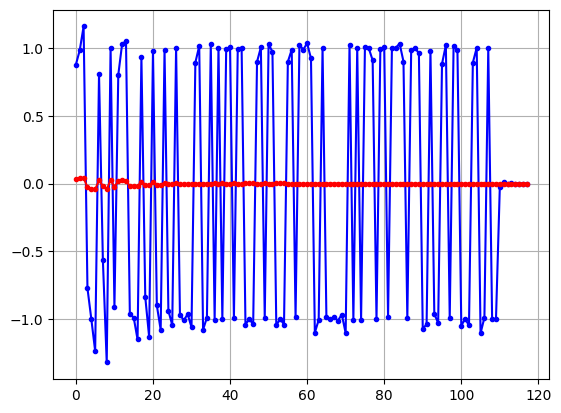

In [37]:
plt.plot(np.real(out), 'b.-')
plt.plot(np.imag(out), 'r.-')
plt.grid(True)
plt.show()


In [38]:
# Demod BPSK
bits_out = (np.real(out) > 0).astype(int) # 1's and 0's
print(bits_out[0:22])


[1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0]


In [39]:
bytes_out = np.packbits(bits_out[22:])
msg_out = bytes_out.tobytes()
print(msg_out)


b'Hello WorldY'


# References
- [ ] [modulation_demodulation.py](https://gitlab.eurecom.fr/florian.kaltenberger/comlab/-/blob/main/modulation_demodulation.py)